# SIFT image alignment tutorial

SIFT (Scale-Invariant Feature Transform) is an algorithm developped by David Lowe in 1999. It is a worldwide reference for image alignment and object recognition. The robustness of this method enables to detect features at different scales, angles and illumination of a scene. Silx provides an implementation of SIFT in OpenCL, meaning that it can run on Graphics Processing Units and Central Processing Units as well. Interest points are detected in the image, then data structures called *descriptors* are built to be characteristic of the scene, so that two different images of the same scene have similar descriptors. They are robust to transformations like translation, rotation, rescaling and illumination change, which make SIFT interesting for image stitching. In the fist stage, descriptors are computed from the input images. Then, they are compared to determine the geometric transformation to apply in order to align the images. This implementation can run on most graphic cards and CPU, making it usable on many setups. OpenCL processes are handled from Python with PyOpenCL, a module to access OpenCL parallel computation API.

This tutuorial explains the three subsequent steps:

* keypoint extraction
* Keypoint matching
* image alignment

All the tutorial has been made using the Jupyter notebook.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


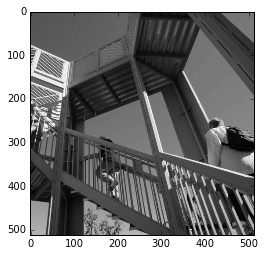

In [2]:
# display test image
import scipy.misc
image = scipy.misc.ascent()
imshow(image, cmap="gray")

In [3]:
#Initialization of the sift object is time consuming: it compiles all the code.
import os 
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "0" #set to 1 to see the compilation going on
from silx.image import sift
%time sift_ocl = sift.SiftPlan(template=image, devicetype="CPU") #switch to GPU to test your graphics card

CPU times: user 652 ms, sys: 40 ms, total: 692 ms
Wall time: 437 ms


/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/pyopencl/__init__.py:207: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In [4]:
print("Time for calculating the keypoints on one image of size %sx%s"%image.shape)
%time keypoints = sift_ocl(image)
print("Number of keypoints: %s"%len(keypoints))
print("Keypoint content:")
print(keypoints.dtype)
print("x: %.3f \t y: %.3f \t sigma: %.3f \t angle: %.3f" % 
      (keypoints[-1].x,keypoints[-1].y,keypoints[-1].scale,keypoints[-1].angle))
print("descriptor:")
print(keypoints[-1].desc)

Time for calculating the keypoints on one image of size 512x512
CPU times: user 1.63 s, sys: 164 ms, total: 1.8 s
Wall time: 883 ms
Number of keypoints: 491
Keypoint content:
(numpy.record, [('x', '<f4'), ('y', '<f4'), ('scale', '<f4'), ('angle', '<f4'), ('desc', 'u1', (128,))])
x: 287.611 	 y: 127.560 	 sigma: 47.461 	 angle: 0.503
descriptor:
[  0   0   0   0   0   0   0   0  13   0   0   5   3   0   0   2  49  12
   5   0   0   0   5  27   1   3   7   0   0   0   3   4   0   7  13  24
  40   0   0   0  61  11   4  72 127   3   0   8 127  92  34   3   7   0
   2  54  22  48  52   0   0   7  14  18   0  33 111 101 127   6   0   0
  33 127  37  64 127  11   0   4 125 127  91  17   5   0   7  54  20   8
  10  12   9  37  50  39   0   2  14  30 127  97   5   0  53  40   6  25
 119  58  15  54  58  30  17  13   7   7  12  67   0   0   2  21  36  25
   4   1]


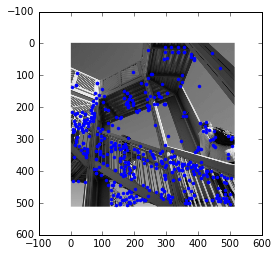

In [5]:
#Overlay keypoints on the image:
imshow(image, cmap="gray")
plot(keypoints[:].x, keypoints[:].y,".")

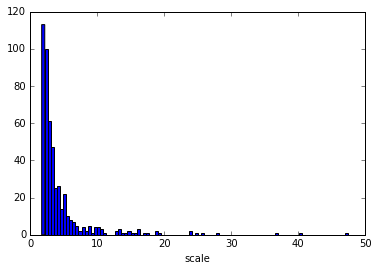

In [6]:
#Diplaying keypoints by scale:
hist(keypoints[:].scale, 100)
xlabel("scale")

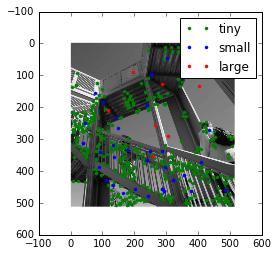

In [9]:
#One can see 3 groups of keypoints, boundaries at: 8 and 20. Let's display them using colors.
S = 8
L = 20
tiny = keypoints[keypoints[:].scale<S]
small = keypoints[numpy.logical_and(keypoints[:].scale<L,keypoints[:].scale>=S)]
bigger = keypoints[keypoints[:].scale>=L]
imshow(image, cmap="gray")
plot(tiny[:].x, tiny[:].y,".g", label="tiny")
plot(small[:].x, small[:].y,".b", label="small")
plot(bigger[:].x, bigger[:].y,".r", label="large")
legend()

## Image matching and alignment

Matching can also be performed on the device (GPU) as every single keypoint from an image needs to be compared with all
keypoints from the second image.

In this simple example we will simple offset the first image by a few pixels

In [10]:
shifted = numpy.zeros_like(image)
shifted[5:,8:] = image[:-5, :-8]
shifted_points = sift_ocl(shifted)

In [17]:
%time mp = sift.MatchPlan()
%time match = mp(keypoints, shifted_points)
print("Number of Keypoints with for image 1 : %i, For image 2 : %i, Matching keypoints: %i" % (keypoints.size, shifted_points.size, match.shape[0]))
from numpy import median
print("Measured offsets dx: %.3f, dy: %.3f"%(median(match[:,1].x-match[:,0].x),median(match[:,1].y-match[:,0].y)))

CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 71.1 ms
CPU times: user 80 ms, sys: 4 ms, total: 84 ms
Wall time: 21 ms
Number of Keypoints with for image 1 : 491, For image 2 : 489, Matching keypoints: 424
Measured offsets dx: 8.000, dy: 5.000


/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/pyopencl/__init__.py:207: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In [21]:
# Example of usage of the automatic alignment:
sa = sift.LinearAlign(image)
sa.align(image)

/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/pyopencl/__init__.py:207: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


TypeError: 'dict_keys' object does not support indexing

### References

- David G. Lowe, Distinctive image features from scale-invariant keypoints, International Journal of Computer Vision, vol. 60, no 2, 2004, p. 91–110 - "http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf"

